# FINM 250 - TA Review 3 - CAPM
## Tobias Rodriguez

## 1. What is the CAPM?

### 1.1 Overview

It states that **in the long run**, the expected return of a stock is equal to the risk-free rate plus a risk premium that is proportional to the stock's beta. That is, all returns are explained by the market:

$$
\mathbb{E}[r_i] = \beta_i \mathbb{E}[r_m]
$$
Where
$$
\beta_i = \frac{\text{Cov}(r_i, r_m)}{\text{Var}(r_m)}
$$

Typicall, we use the S&P 500 as a proxy for the market. The risk-free rate is normally the yield of the 3-month Treasury bill (or the repo rate). The broad class of "factor models" is a generalization of the CAPM. That is, the *core* idea of a factor model is that all returns are explained by a set of factors:

$$
\mathbb{E}[r_i] = \beta_{i,1} \mathbb{E}[r_{1}] + \beta_{i,2} \mathbb{E}[r_{2}] + \dots + \beta_{i,k} \mathbb{E}[r_{k}]
$$

For those who have seen factor models in statistics classes, they are the same thing. In typical factor model notation:

$$
\boldsymbol{X} = \boldsymbol{L} \boldsymbol{F} + \boldsymbol{\epsilon}
$$

Where $\boldsymbol{X}$ is a $p \times 1$ vector of features, $\boldsymbol{L}$ is a $p \times m$ *loadings* matrix, and $\boldsymbol{F}$ is a $m \times 1$ vector of uncorrelated, unobserved factors.

Most of the effort in constructing these kinds of models is in estimating the factors. Note how the response, $\boldsymbol{X}$, is *linear* in the loadings matrix. Thus, we can estimate the loadings matrix using linear regression. Importantly, being able to set up the factor model as a linear regression means that we can use all the very powerful tools that linear regression unlocks.

What statistical tool might we use to "go fishing" for factors? Hint: it involves the covariance matrix and uncorrelated vectors.

### 1.2 Implications

- $\alpha$, the intercept of the regression should be zero (or statistically indistinguishable from zero).
- The $R^2$ **does not matter** because the CAPM only care about the long run, not the deviations from the long run.
- Information ratio should be 0 (since $\alpha$ is 0).
- Treynor Ratio for *any* assets should be the same (since any differences in mean-returns can only be explained by differences in $\beta$).

### 1.3 Trading Strategies

How would you actually trade on the CAPM or a factor model? Well, consider that this is a pricing model. That is, it tells you what the *fair price* of an asset is (in terms of returns). So, if you have a lot of confidence in your factor model, you now have a theoretical price for every asset. 

If the market price is above your long-term theoretical price, you should short the asset. If the market price is below your long-term theoretical price, you should buy the asset.

Momentum was made popular by AQR ("Applied Quantitative Research"), a hedge fund. [A Half Century of Macro Momentum](https://www.aqr.com/Insights/Research/White-Papers/A-Half-Century-of-Macro-Momentum).

### 1.4 Misc. Regression Questions

These are all from interviews I've had or heard about. Again, these are not required for the class, but they are good to think about.

- Give the closed form solution for linear regression and the residuals.
- What happens to the betas, intercept, and R^2 if there is some measurement error in your X variables? What about Y?
- How do I determine if my betas are statistically significant?
- When would you want to use a weighted regression? What about a robust regression?
- What is the difference between a linear regression and a logistic regression? What is the canonical link function for a logistic regression?
- What is the closed form solution for a logistic regression? And Ridge regression?
- What is the difference between Ridge and Lasso regression?
- How would you determine if your regression is overfitting?

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt

# This is a new trick that we can use to import modules from other directories.
import sys

# We append it to "path" meaning that Python will look in this directory when we try to import modules.
# Note that ".." means go up one directory, and then we go into the "cmds" directory.
sys.path.append("../cmds")
from utils import calc_iterative_regression

# Auto reload modules.
%load_ext autoreload
%autoreload 2

# Plotting settings.
plt.rcParams["axes.grid"] = True
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False
plt.style.use("bmh")

pd.set_option("display.float_format", lambda x: "{:.4f}".format(x))

ADJ = 12
factors = pd.read_excel(
    "../data/factor_pricing_data.xlsx",
    sheet_name="factors (excess returns)",
    index_col=0,
    parse_dates=[0],
)

spy = factors[["MKT"]]

assets = pd.read_excel(
    "../data/factor_pricing_data.xlsx",
    sheet_name="portfolios (excess returns)",
    index_col=0,
    parse_dates=[0],
)

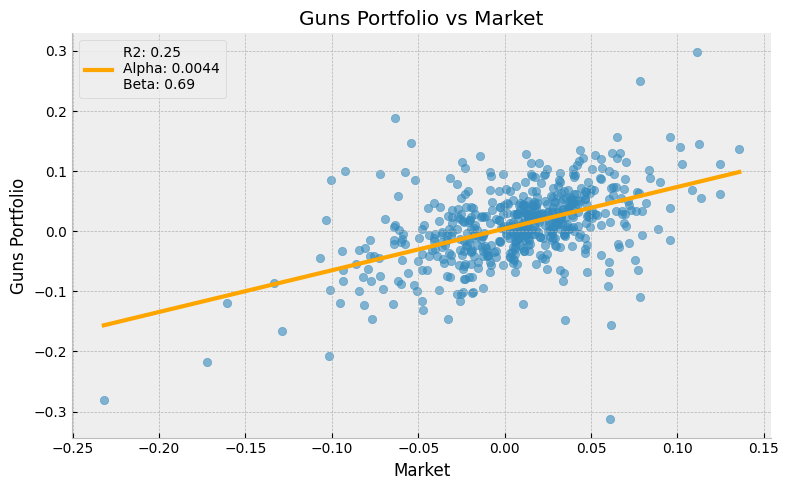

In [ ]:
# Plot, Guns portfolio vs market with a linear regression line.
fig, ax = plt.subplots(figsize=(8, 5))
ax.scatter(spy, assets["Guns "], alpha=0.6)
ax.set_xlabel("Market")
ax.set_ylabel("Guns Portfolio")
ax.set_title("Guns Portfolio vs Market")

# Calculate the linear regression.
X = sm.add_constant(spy)
model = sm.OLS(assets["Guns "], X)
results = model.fit()
beta = results.params["MKT"]
alpha = results.params["const"]
r2 = results.rsquared
x = np.linspace(spy.min(), spy.max(), 100)
ax.plot(x, alpha + beta * x, c='orange', label=f"R2: {r2:.2f}\nAlpha: {alpha:.4f}\nBeta: {beta:.2f}", lw=3)
ax.legend()
fig.tight_layout()

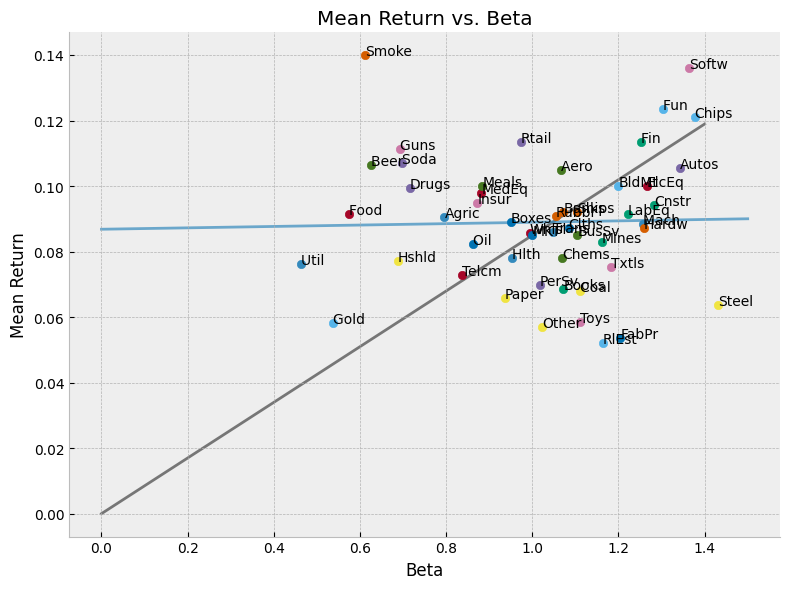

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))

assets["MKT"] = spy

betas = []
means = []

spy_const = sm.add_constant(spy)
for asset in assets.columns:
    regr = sm.OLS(assets[asset], spy_const).fit()
    ax.scatter(regr.params[1], assets[asset].mean() * ADJ, label=asset, zorder=2)
    ax.annotate(asset, (regr.params[1], assets[asset].mean() * ADJ), zorder=3)
    betas.append(regr.params[1])
    means.append(assets[asset].mean() * ADJ)

ax.plot([0, 1.4], [0, spy.mean()[0] * ADJ * 1.4], c="black", zorder=1, alpha=0.5)
beta_mean_regr = sm.OLS(means, sm.add_constant(betas)).fit()

ax.plot(
    np.arange(0, 1.6, 0.1),
    beta_mean_regr.params[0] + beta_mean_regr.params[1] * np.arange(0, 1.6, 0.1),
    zorder=1,
    alpha=0.7,
)

ax.set_yticks(np.arange(0, 0.15, 0.02))
ax.set_xticks(np.arange(0, 1.6, 0.2))
ax.set_title("Mean Return vs. Beta")
ax.set_xlabel("Beta")
ax.set_ylabel("Mean Return")
fig.tight_layout()

### 1.5 Expanding to Multiple Factors

So maybe the CAPM is not enough, BUT we think that there are some other factors that explain returns. How do we construct a factor model?

Size (SMB): Small-cap stocks tend to outperform large-cap stocks. So, we can construct a factor that is long small-cap stocks and short large-cap stocks.

$$
SMB = \frac{1}{2} \cdot \text{Small Cap} - \frac{1}{2} \cdot \text{Large Cap}
$$

Is this uncorrelated to the market? Well, note that the market factor should just be all stocks (small plus large), meaning that if we think about the correlation between the market and SMB, then it should be uncorrelated.

Value (HML): Value stocks tend to outperform growth stocks. So, we can construct a factor that is long value stocks and short growth stocks.

$$
HML = \frac{1}{2} \cdot \text{Value} - \frac{1}{2} \cdot \text{Growth}
$$

Is this uncorrelated to the market? Yes, since we have long/short positions in both value and growth stocks, the market factor should be uncorrelated to HML. 

What about SMB and HML? Uh oh! They might be correlated. Suppose that most growth stocks tend to be large-cap (tech!) and most value stocks might be small-cap. Then we might have a correlation between SMB and HML. How can we fix this? We can expand HML to instead be cut on size and value, so:

$$
HML = \frac{1}{2} \cdot \text{Small Value} - \frac{1}{2} \cdot \text{Small Growth} + \frac{1}{2} \cdot \text{Large Value} - \frac{1}{2} \cdot \text{Large Growth}
$$

Now we have a factor model that is uncorrelated to the market and has no correlation between SMB and HML (3 orthogonal factors).

### 1.6 How do we "fish" for factors?

What would give us orthogonal vectors that explain the variance of returns?

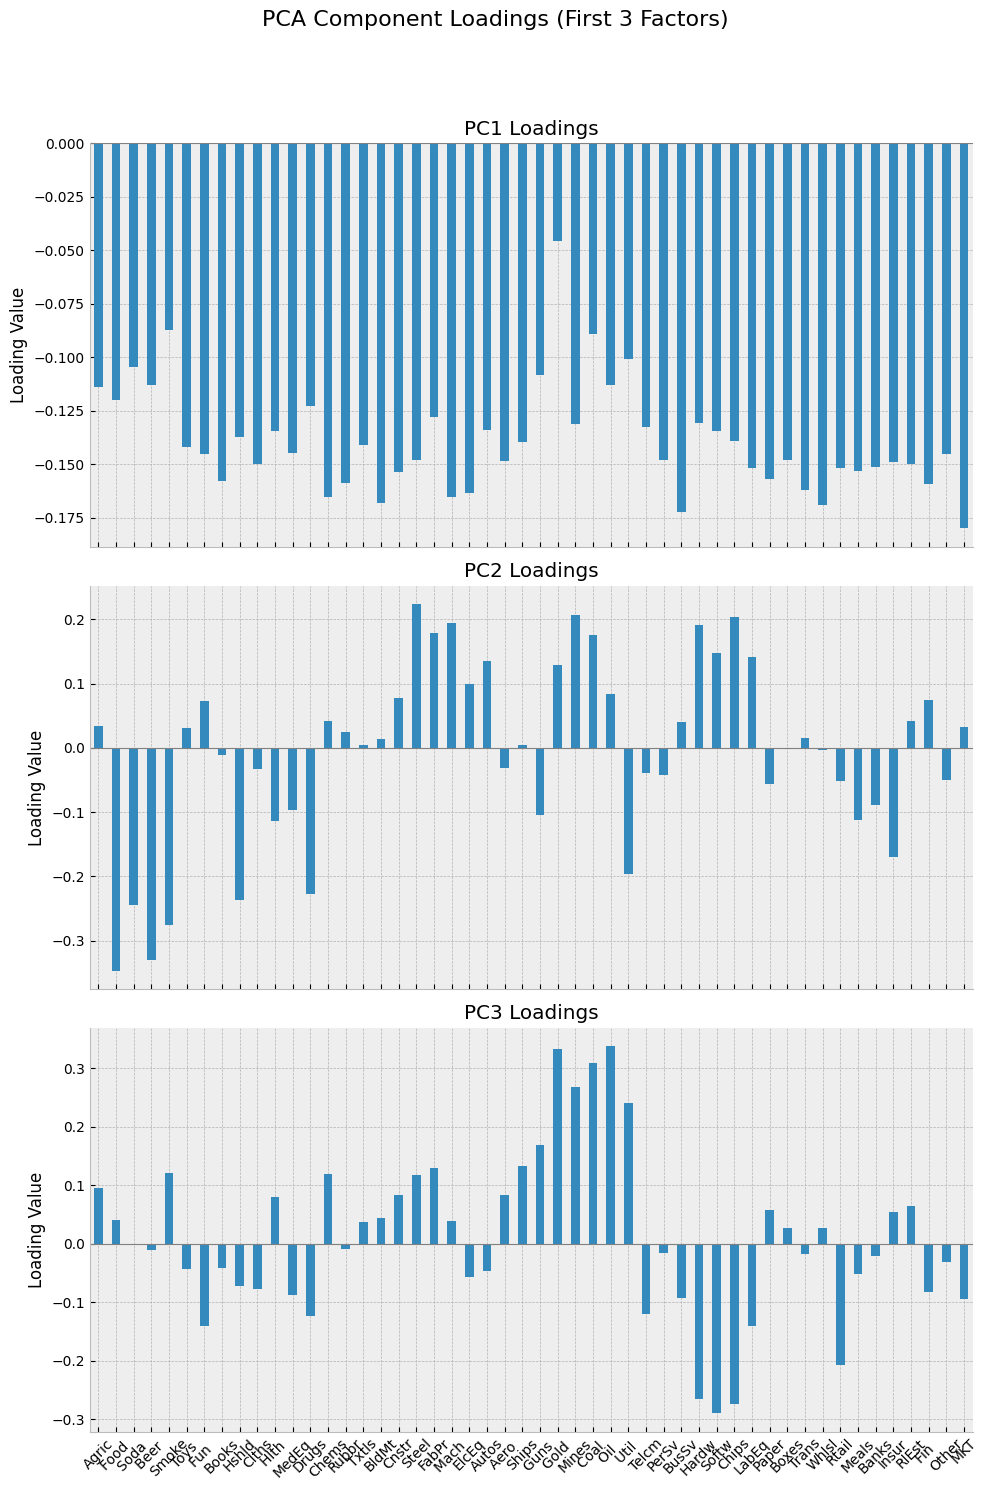

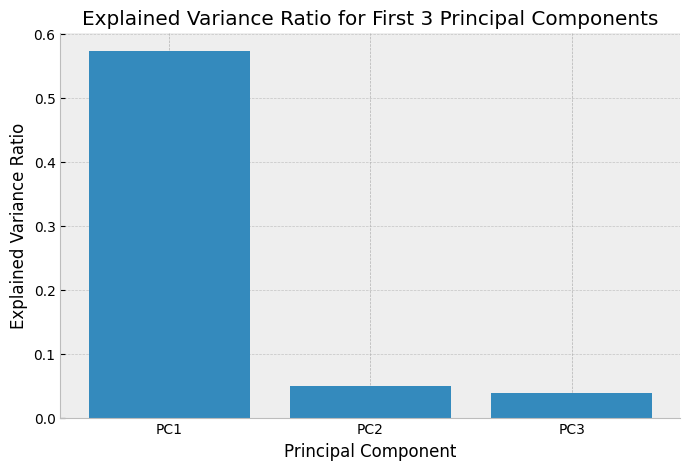

PCA analysis complete.
Explained Variance Ratio for the first 3 components: [0.57369575 0.04956725 0.03832221]
Cumulative Explained Variance: 0.6616


In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

n_components_to_consider = 3    
scaler = StandardScaler()
scaled_assets = scaler.fit_transform(assets)
scaled_assets_df = pd.DataFrame(scaled_assets, columns=assets.columns)

pca = PCA(n_components=n_components_to_consider)
pca.fit(scaled_assets_df)

loadings = pd.DataFrame(
    pca.components_.T,
    columns=[f'PC{i+1}' for i in range(n_components_to_consider)],
    index=assets.columns
)

fig, axes = plt.subplots(n_components_to_consider, 1, figsize=(10, 5 * n_components_to_consider), sharex=True)

fig.suptitle('PCA Component Loadings (First 3 Factors)', y=1.02, fontsize=16)

for i in range(n_components_to_consider):
    ax = axes[i]
    component_name = f'PC{i+1}'
    loadings[component_name].plot(kind='bar', ax=ax, zorder=2)
    ax.set_title(f'{component_name} Loadings')
    ax.set_ylabel('Loading Value')
    ax.axhline(0, color='gray', linewidth=0.8)
    ax.tick_params(axis='x', rotation=45)
plt.tight_layout(rect=[0, 0.03, 1, 0.98])
plt.show()

plt.figure(figsize=(8, 5))
explained_variance_ratio = pca.explained_variance_ratio_
components_labels = [f'PC{i+1}' for i in range(n_components_to_consider)]

plt.bar(components_labels, explained_variance_ratio, zorder=2)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio for First 3 Principal Components')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

print("PCA analysis complete.")
print(f"Explained Variance Ratio for the first {n_components_to_consider} components: {explained_variance_ratio}")
print(f"Cumulative Explained Variance: {np.cumsum(explained_variance_ratio)[-1]:.4f}")

## Python

### Python Tidbit #1: How to Make Your For Loops Smarter

In [ ]:
# Example 1: Calculating something from two lists of the same length.
tax_rate = [i / 10 for i in range(1, 11)]
income_rate = [i * 1000 for i in range(50, 61)]
tax_paid = []

# You might be tempted to do something like this:
for idx in range(len(tax_rate)):
    tax = tax_rate[idx] * income_rate[idx]
    tax_paid.append(tax)

# Or maybe you know what enumerate() does, and you do this:
for idx, rate in enumerate(tax_rate):
    tax = rate * income_rate[idx]
    tax_paid.append(tax)

# But, you can do this instead:
for rate, income in zip(tax_rate, income_rate):
    tax = rate * income
    tax_paid.append(tax)

# And finally, you can combine this into a list comprehension:
tax_paid = [rate * income for rate, income in zip(tax_rate, income_rate)]

In [ ]:
# Example 2: Filtering directly. Suppose we want to filter out all negative numbers from a list.
my_list = [1, 2, 3, -1, -2, -3, 4, 5, 6, -4, -5, -6]

# List comprehension
my_list_filt = [i for i in my_list if i >= 0]

# But suppose you want to append the numbers to a new list, but you can't
# do that in a list comprehension.

my_list_filt = []

for i in my_list:
    if i >= 0:
        my_list_filt.append(i)

# This is somewhat better, but we can do even better with a filter() function.
# Note that this enables you to have some complex logic in the filter, without
# needing to write a bunch of if-else statements; eg.

for i in filter(lambda x: x >= 0, my_list):
    my_list_filt.append(i)


def my_filter(x):
    if x >= 0 and x % 2 == 0 and x < 5 and x != 3:
        return True
    return False


for i in filter(my_filter, my_list):
    my_list_filt.append(i)

# This is rarely used, but suppose you wanted to invert
# the logic of the complicated my_filter() function. You can use
# itertools.filterfalse() to do this.
from itertools import filterfalse

for i in filterfalse(my_filter, my_list):
    my_list_filt.append(i)



In [ ]:
# Example 3: Using previous/next values without having to use indices.
my_list = [i for i in range(10)]

# Suppose we want to calculate the difference between each value and the next value.
# We could do this:
diffs = []
for idx in range(len(my_list) - 1):
    diff = my_list[idx + 1] - my_list[idx]
    diffs.append(diff)

# Or maybe something that uses enumerate():
for idx, val in enumerate(my_list[:-1]):
    diff = my_list[idx + 1] - val
    diffs.append(diff)

# Or we could use zip():
for val, next_val in zip(my_list[:-1], my_list[1:]):
    diff = next_val - val
    diffs.append(diff)

# But we could just save ourselves the trouble and use the itertools module!
# This is VERY useful when dealing with, for example, time series data. If
# you look at my solution for 3.6 for Homework 1, you'll see that I used it to
# calculate the training and testing sets.
from itertools import pairwise

for val, next_val in pairwise(my_list):
    diff = next_val - val
    diffs.append(diff)

# Of course, if this was a job interview and you wanted to show off, do:
diffs = list(map(lambda x: x[0] - x[1], pairwise(my_list)))

Why might you care about smarter for-loops and python built-ins?

https://leetcode.com/problems/ransom-note/description/

Given two strings ransomNote and magazine, return true if ransomNote can be constructed by using the letters from magazine and false otherwise.

Each letter in magazine can only be used once in ransomNote.
 
```
Example 1:

Input: ransomNote = "a", magazine = "b"
Output: false

Example 2:

Input: ransomNote = "aa", magazine = "ab"
Output: false

Example 3:

Input: ransomNote = "aa", magazine = "aab"
Output: true
```


Constraints:
```
1 <= ransomNote.length, magazine.length <= 105
ransomNote and magazine consist of lowercase English letters.
```


In [ ]:
# Long solution...
def can_construct(ransomNote: str, magazine: str) -> bool:
    ransom_dict = {}
    
    for r in ransomNote:
        if r in ransom_dict:
            ransom_dict[r] += 1
        else:
            ransom_dict[r] = 1
    
    magazine_dict = {}
    
    for m in magazine:
        if m in magazine_dict:
            magazine_dict[m] += 1
        else:
            magazine_dict[m] = 1
            
    for letter, count in ransom_dict.items():
        if letter in magazine_dict and magazine_dict[letter] >= count:
            continue
        return False
    return True

In [ ]:
# First pass improvement
def can_construct_better(ransomNote: str, magazine: str) -> bool:
    from collections import defaultdict
    
    ransom_dict = defaultdict(1)
    magazine_dict = defaultdict(1)
    
    for r in ransomNote:
        ransom_dict[r] += 1
    
    for m in magazine:
        magazine_dict[m] += 1
        
    for letter, count in ransom_dict.items():
        if letter in magazine_dict and magazine_dict[letter] >= count:
            continue
        return False
    return True

In [ ]:
# Second pass
# https://docs.python.org/3/library/collections.html#collections.Counter
def can_construct_even_better(ransomNote: str, magazine: str) -> bool:
    from collections import Counter
    cr = Counter(ransomNote)
    cm = Counter(magazine)
        
    for k, v in cr.items():
        if k in cm and cm[k] >= v:
            continue
        return False
    return True

In [ ]:
# Final pass
def can_construct_best(ransomNote: str, magazine: str) -> bool:
    from collections import Counter
    
    return not (
        Counter(ransomNote) - Counter(magazine)
    )

In [ ]:
# Is it better???
def make_count(s: str):
    d = {}
    for c in s:
        if c in d:
            d[c] += 1
        else:
            d[c] = 1
    return d

%timeit make_count('paoduihfjzosdfghbaposdufhasdpuiofhsaduipfhasuiodfhuoiasdhfuioasdfhi')

In [ ]:
from collections import Counter

%timeit Counter('paoduihfjzosdfghbaposdufhasdpuiofhsaduipfhasuiodfhuoiasdhfuioasdfhi')

2.06 µs ± 59.9 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)
